In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from IPython.display import display

In [2]:
# 1.b - Load dataset
df = pd.read_csv('uber.csv')

In [3]:
# 1.c - Initial EDA
print("=== Initial Data Structure ===")
display(pd.DataFrame({'columns': df.columns, 'dtype': df.dtypes, 'missing': df.isnull().sum()}))
display(pd.DataFrame({'rows':[df.shape[0]], 'columns':[df.shape[1]]}))
display(df.describe(include='all'))
print("\n=== Passenger Count Distribution ===")
display(df['passenger_count'].value_counts().to_frame('count'))
print("\n=== Temporal Range ===")
display(pd.DataFrame({'min':[df['pickup_datetime'].min()], 'max':[df['pickup_datetime'].max()]}))

=== Initial Data Structure ===


,columns,dtype,missing
Unnamed: 0,Unnamed: 0,int64,0
key,key,object,0
fare_amount,fare_amount,float64,0
pickup_datetime,pickup_datetime,object,0
pickup_longitude,pickup_longitude,float64,0
pickup_latitude,pickup_latitude,float64,0
dropoff_longitude,dropoff_longitude,float64,1
dropoff_latitude,dropoff_latitude,float64,1
passenger_count,passenger_count,int64,0


,rows,columns
0,200000,9


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000,200000.000000,200000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
unique,NaN,200000,NaN,196629,NaN,NaN,NaN,NaN,NaN
top,NaN,2015-05-07 19:52:06.0000003,NaN,2014-04-13 18:19:00 UTC,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,4,NaN,NaN,NaN,NaN,NaN
mean,2.771250e+07,NaN,11.359955,NaN,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,NaN,9.901776,NaN,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,NaN,-52.000000,NaN,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,NaN,6.000000,NaN,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,NaN,8.500000,NaN,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,NaN,12.500000,NaN,-73.967154,40.767158,-73.963658,40.768001,2.000000



=== Passenger Count Distribution ===


,count
passenger_count,
1,138425
2,29428
5,14009
3,8881
4,4276
6,4271
0,709
208,1



=== Temporal Range ===


,min,max
0,2009-01-01 01:15:22 UTC,2015-06-30 23:40:39 UTC


In [10]:
# 1.d - Data Cleaning
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'key'], errors='ignore')
# Convert datetime and extract features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
# Handle missing values
numeric_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mode()[0]).astype(int)
# Filter invalid data
df = df[df['fare_amount'] >= 2.50]
nyc_bounds = {'min_lon': -74.03, 'max_lon': -73.75, 'min_lat': 40.63, 'max_lat': 40.85}
df = df[
    (df['pickup_longitude'].between(nyc_bounds['min_lon'], nyc_bounds['max_lon'])) &
    (df['pickup_latitude'].between(nyc_bounds['min_lat'], nyc_bounds['max_lat'])) &
    (df['dropoff_longitude'].between(nyc_bounds['min_lon'], nyc_bounds['max_lon'])) &
    (df['dropoff_latitude'].between(nyc_bounds['min_lat'], nyc_bounds['max_lat']))
]
df = df[df['passenger_count'].between(1, 6)]
# Calculate accurate distance (Haversine)
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return 6371 * c  # Earth radius in km
df['distance_km'] = df.apply(
    lambda row: haversine(
        row['pickup_longitude'], row['pickup_latitude'],
        row['dropoff_longitude'], row['dropoff_latitude']
    ), axis=1
)
df = df[df['distance_km'] > 0.1]  # Remove trips < 100m
# Remove distance outliers
Q1 = df['distance_km'].quantile(0.25)
Q3 = df['distance_km'].quantile(0.75)
IQR = Q3 - Q1
df = df[df['distance_km'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]

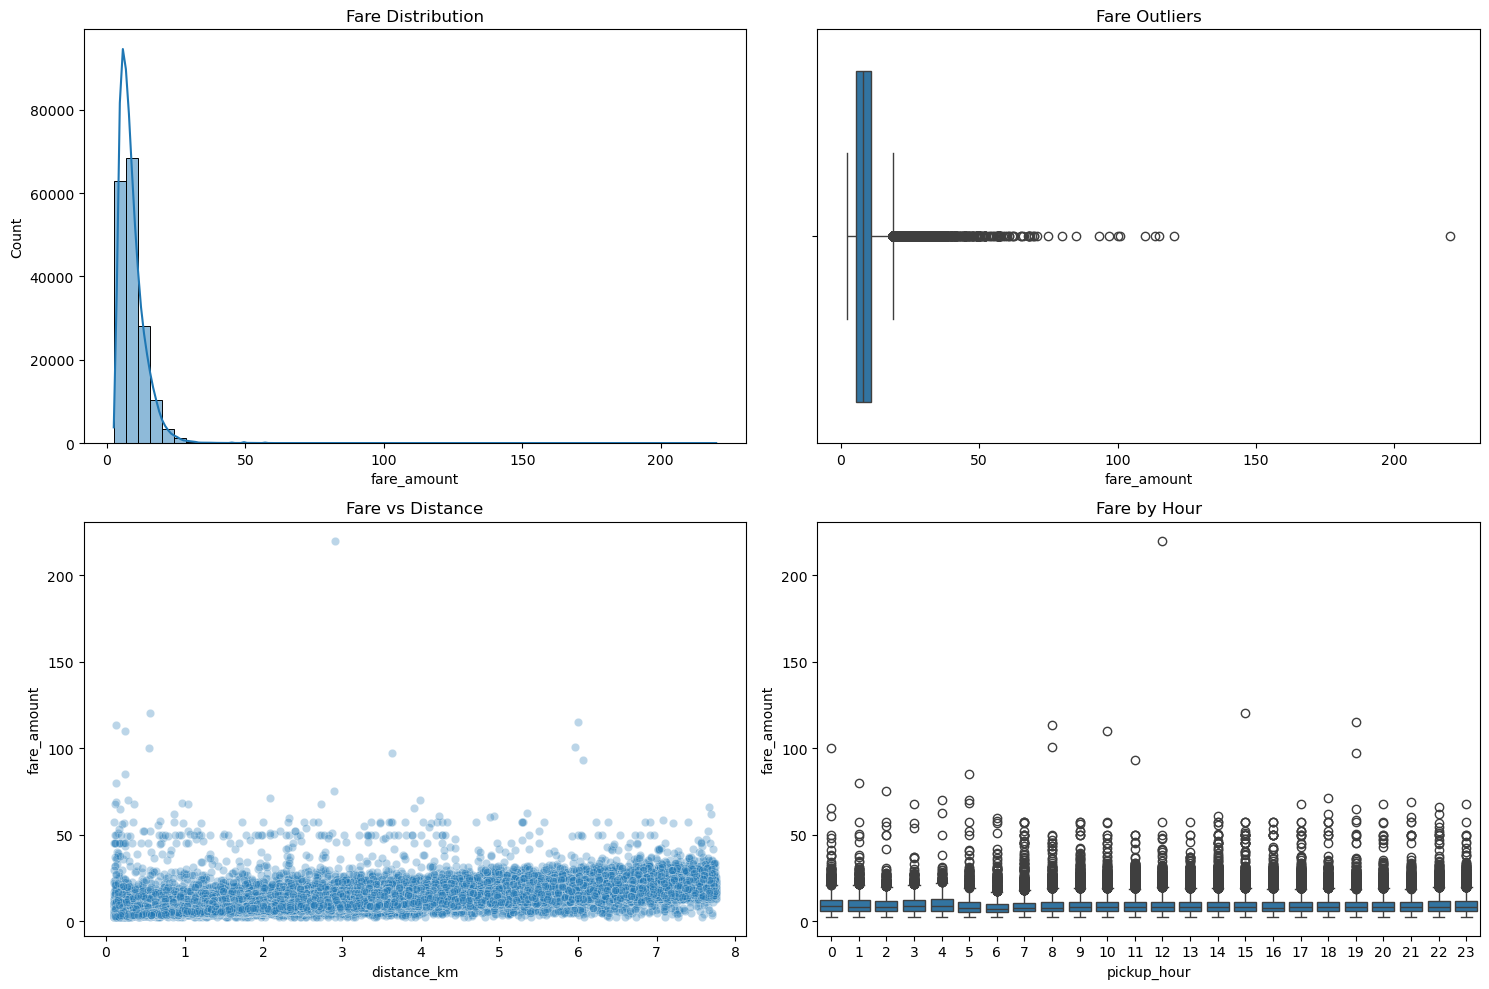

In [9]:
# 2.b - Visualizations
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Fare Distribution')
plt.subplot(2, 2, 2)
sns.boxplot(x=df['fare_amount'])
plt.title('Fare Outliers')
plt.subplot(2, 2, 3)
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.3)
plt.title('Fare vs Distance')
plt.subplot(2, 2, 4)
sns.boxplot(x='pickup_hour', y='fare_amount', data=df)
plt.title('Fare by Hour')
plt.tight_layout()
plt.show()


=== Correlation Matrix ===


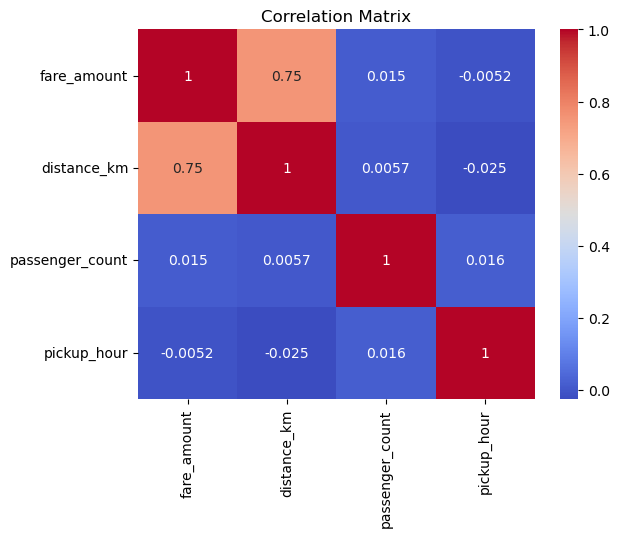

In [14]:
# 2.c - Correlations
print("\n=== Correlation Matrix ===")
corr = df[['fare_amount', 'distance_km', 'passenger_count', 'pickup_hour']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# 1.e - Export cleaned data
df.to_csv('uber_cleaned.csv', index=False)
print("Data cleaning and EDA complete. Cleaned data saved to 'uber_cleaned.csv'")

Data cleaning and EDA complete. Cleaned data saved to 'uber_cleaned.csv'


In [13]:
import pandas as pd

# Load your cleaned dataset (replace 'uber.csv' with your actual filename if different)
df = pd.read_csv('uber.csv')

# ==============================================
# 3. Feature Engineering
# ==============================================

# ----------
# 3.a Temporal Features
# ----------
# Convert to datetime (ensure UTC for consistency)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)

# Extract time components
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_name'] = df['pickup_datetime'].dt.day_name()

# Define peak hours (weekdays 7-9 AM, 5-7 PM; weekends 8 PM-12 AM)
df['is_peak'] = (
    ((df['pickup_dayofweek'] < 5) & (df['pickup_hour'].isin([7, 8, 9, 17, 18, 19]))) |  # Weekdays
    ((df['pickup_dayofweek'] >= 5) & (df['pickup_hour'].isin([20, 21, 22, 23])))       # Weekends
).astype('int8')

# ----------
# 3.b Categorical Encoding
# ----------
# One-hot encode day of week
df = pd.get_dummies(df, columns=['day_name'], prefix='day', dtype='int8')

# NYC Boroughs (optimized bounding boxes)
def get_borough(lon, lat):
    if -74.05 <= lon <= -73.70 and 40.58 <= lat <= 40.92:  # Expanded NYC area
        if -74.02 <= lon <= -73.85 and 40.68 <= lat <= 40.82:
            return 'Manhattan'
        elif -73.95 <= lon <= -73.75 and 40.58 <= lat <= 40.72:
            return 'Brooklyn'
        elif -73.90 <= lon <= -73.65 and 40.63 <= lat <= 40.78:
            return 'Queens'
        elif -73.95 <= lon <= -73.75 and 40.78 <= lat <= 40.92:
            return 'Bronx'
    return 'Other'

df['pickup_borough'] = df.apply(
    lambda row: get_borough(row['pickup_longitude'], row['pickup_latitude']), 
    axis=1
)
df = pd.get_dummies(df, columns=['pickup_borough'], prefix='borough', dtype='int8')

# Passenger categories (1, 2, 3-4, 5+)
df['passenger_category'] = df['passenger_count'].apply(
    lambda x: '1' if x == 1 else '2' if x == 2 else '3-4' if x <= 4 else '5+'
)
df = pd.get_dummies(df, columns=['passenger_category'], prefix='passengers', dtype='int8')

# ----------
# 3.c Data Type Optimization
# ----------
# Ensure correct types
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)  # Force UTC
coord_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
df[coord_cols] = df[coord_cols].astype('float32')  # Saves 50% memory vs. float64

# ----------
# Export for Power BI
# ----------
df.to_csv('uber_enhanced.csv', index=False, encoding='utf-8-sig')
print("Enhanced dataset saved to 'uber_enhanced.csv'")
print(f"Final shape: {df.shape}")

Enhanced dataset saved to 'uber_enhanced.csv'
Final shape: (200000, 30)
